### **Задача 2: Прогнозирование количества заказов такси**

**Описание:**
У вас есть данные по заказам такси в разных районах города за последние 30 дней. Доступны следующие признаки:

* день недели,
* количество ресторанов в районе,
* средний доход населения,
* температура,
* количество заказов такси.

**Проблема:**
Данные содержат:

* пропущенные значения (например, по температуре или доходу),
* выбросы в количестве заказов (праздничные дни),
* подозрительные кластеры по всем признакам.

**Требуется:**

1. Заполнить пропуски (возможны численные и категориальные методы).
2. Обнаружить и обработать выбросы:

   * с помощью IQR по количеству заказов,
   * с помощью кластеризации (`DBSCAN`) по всем признакам.
3. Построить линейную регрессию для прогнозирования количества заказов.

**Цель:**
Оценить влияние очистки данных на точность прогноза и выделить аномальные районы.

Пример данных:
   day_of_week  restaurants       income  temperature      orders
0            6           13  3217.777924    24.296286  268.349522
1            3           13  3446.131830    21.730889  211.660298
2            4           14  3293.339104    12.195545  203.016096
3            6           11  3340.503119    12.859846  133.836449
4            2           17  2877.599879    17.138515  169.623683

Количество пропусков:
 day_of_week     0
restaurants     0
income         15
temperature    20
orders          0
dtype: int64

После заполнения пропусков (обучающий набор):
day_of_week    0
restaurants    0
income         0
temperature    0
dtype: int64

Удалено выбросов по IQR: 12
Аномалий DBSCAN: 45
Оставлено после очистки: 343 записей

Обучение модели:

До очистки
MSE: 4029.45, R²: -0.052

После очистки (IQR + DBSCAN)
MSE: 3988.00, R²: -0.041


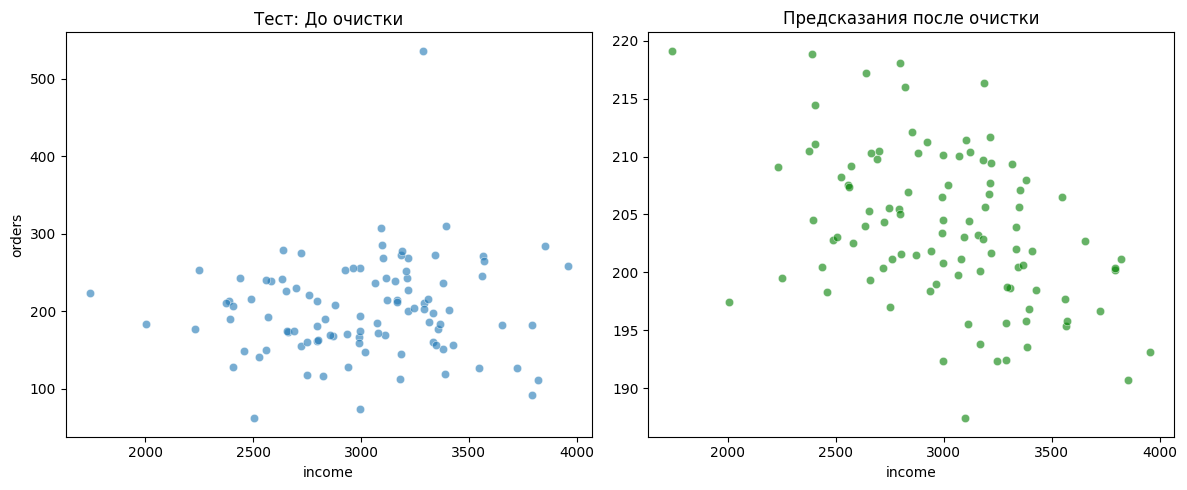

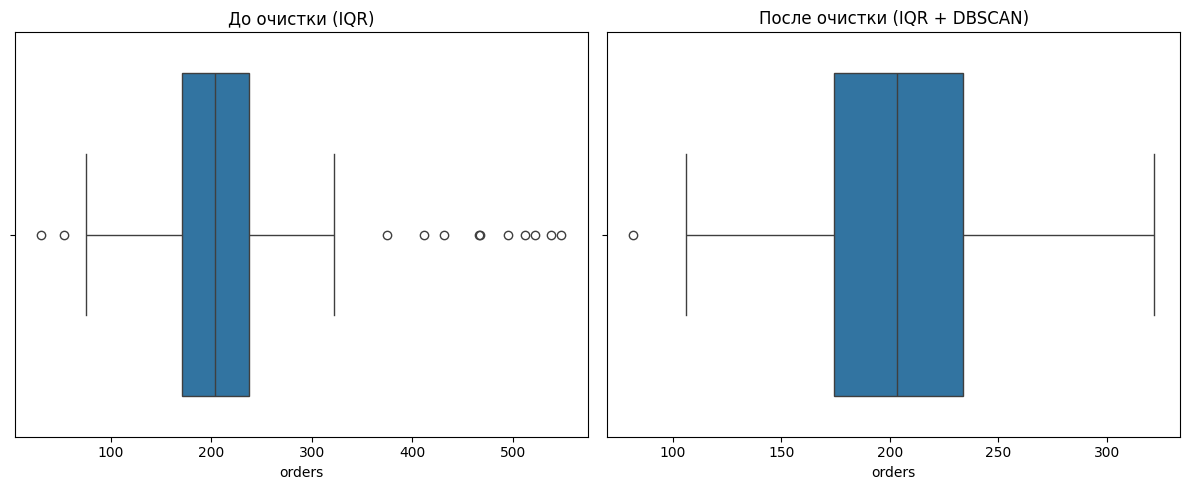

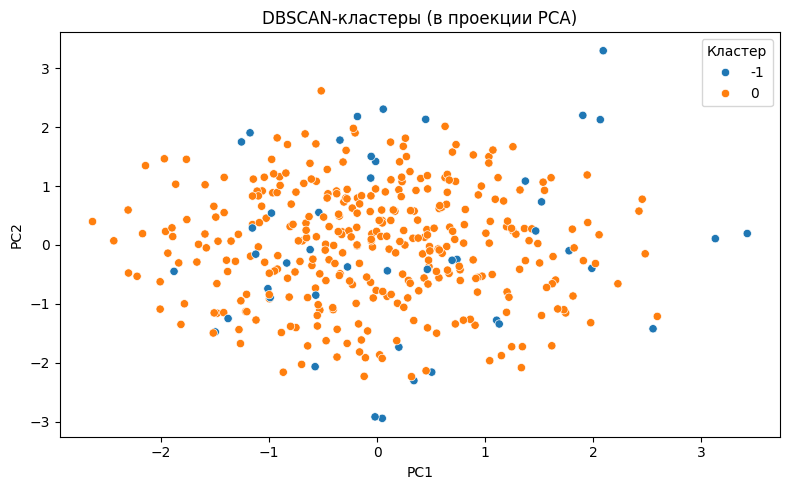


Веса признаков:
       Feature  Coefficient
1  restaurants    -5.021053
3  temperature     2.879051
2       income    -2.070629
0  day_of_week     0.949253


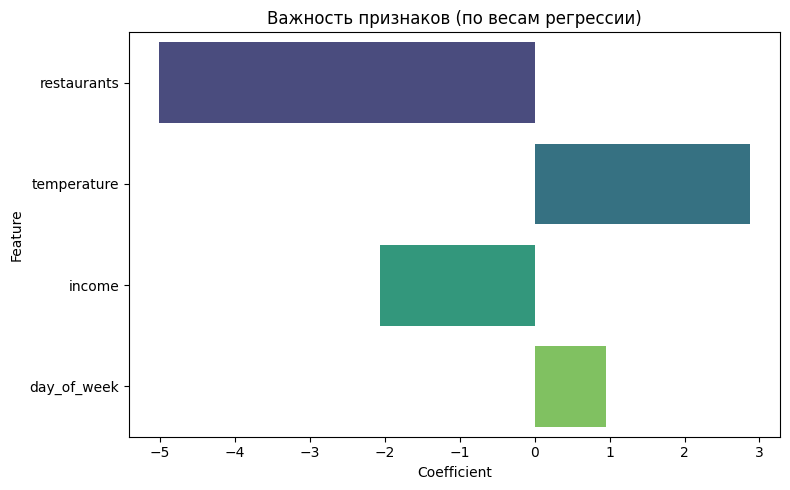

In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

np.random.seed(42)

# Генерация данных
n = 500
data = {
    "day_of_week": np.random.randint(0, 7, n),
    "restaurants": np.random.poisson(15, n),
    "income": np.random.normal(3000, 500, n),
    "temperature": np.random.normal(20, 5, n),
    "orders": np.random.normal(200, 50, n)
}

df = pd.DataFrame(data)
df.loc[np.random.choice(n, 20), "temperature"] = np.nan
df.loc[np.random.choice(n, 15), "income"] = np.nan
df.loc[np.random.choice(n, 10), "orders"] += 300  # выбросы

print("Пример данных:")
print(df.head())
print("\nКоличество пропусков:\n", df.isna().sum())

features = ["day_of_week", "restaurants", "income", "temperature"]
target = "orders"

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train = X_train.copy()
train["orders"] = y_train
test = X_test.copy()
test["orders"] = y_test

# Заполнение пропусков
train["temperature"].fillna(train["temperature"].mean(), inplace=True)
train["income"].fillna(train["income"].median(), inplace=True)
test["temperature"].fillna(train["temperature"].mean(), inplace=True)
test["income"].fillna(train["income"].median(), inplace=True)

print("\nПосле заполнения пропусков (обучающий набор):")
print(train[features].isna().sum())

# Удаление выбросов по IQR
Q1 = train["orders"].quantile(0.25)
Q3 = train["orders"].quantile(0.75)
IQR = Q3 - Q1
mask_iqr = (train["orders"] >= Q1 - 1.5 * IQR) & (train["orders"] <= Q3 + 1.5 * IQR)
train_iqr = train[mask_iqr].copy()
print(f"\nУдалено выбросов по IQR: {len(train) - len(train_iqr)}")

# DBSCAN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_iqr[features + ["orders"]])
dbscan = DBSCAN(eps=1.3, min_samples=5)
labels = dbscan.fit_predict(X_scaled)
train_iqr["dbscan_label"] = labels
print(f"Аномалий DBSCAN: {(labels == -1).sum()}")

train_clean = train_iqr[train_iqr["dbscan_label"] != -1].drop(columns=["dbscan_label"])
print(f"Оставлено после очистки: {len(train_clean)} записей")

# Функция обучения модели
def run_model(train_df, test_df, title=""):
    scaler_model = StandardScaler()
    X_train_scaled = scaler_model.fit_transform(train_df[features])
    X_test_scaled = scaler_model.transform(test_df[features])

    model = LinearRegression()
    model.fit(X_train_scaled, train_df["orders"])
    preds = model.predict(X_test_scaled)

    mse = mean_squared_error(test_df["orders"], preds)
    r2 = r2_score(test_df["orders"], preds)

    print(f"\n{title}\nMSE: {mse:.2f}, R²: {r2:.3f}")
    return preds, test_df["orders"], r2

print("\nОбучение модели:")
raw_train = train.copy()
raw_preds, raw_y, raw_r2 = run_model(raw_train, test, "До очистки")
clean_preds, clean_y, clean_r2 = run_model(train_clean, test, "После очистки (IQR + DBSCAN)")

# Визуализация предсказаний
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=test, x="income", y="orders", alpha=0.6)
plt.title("Тест: До очистки")

plt.subplot(1, 2, 2)
sns.scatterplot(x=test["income"], y=clean_preds, alpha=0.6, color="green")
plt.title("Предсказания после очистки")
plt.tight_layout()
plt.show()

# Boxplot до и после IQR + DBSCAN
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=train["orders"])
plt.title("До очистки (IQR)")

plt.subplot(1, 2, 2)
sns.boxplot(x=train_clean["orders"])
plt.title("После очистки (IQR + DBSCAN)")
plt.tight_layout()
plt.show()

# DBSCAN визуализация через PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=train_iqr["dbscan_label"], palette="tab10", legend="full"
)
plt.title("DBSCAN-кластеры (в проекции PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Кластер")
plt.tight_layout()
plt.show()

# Важность признаков
model = LinearRegression()
model.fit(StandardScaler().fit_transform(train_clean[features]), train_clean["orders"])

coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_
}).sort_values("Coefficient", key=abs, ascending=False)

print("\nВеса признаков:")
print(coef_df)

plt.figure(figsize=(8, 5))
sns.barplot(data=coef_df, x="Coefficient", y="Feature", palette="viridis")
plt.title("Важность признаков (по весам регрессии)")
plt.tight_layout()
plt.show()